## Setup

In [1]:
from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import os
from tqdm import tqdm

from cell_inference.config import paths, params
from cell_inference.cells.simulation import Simulation
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.utils.random_parameter_generator import generate_parameters_from_config
from cell_inference.utils.transform.geometry_transformation import cart2pol
from cell_inference.utils.feature_extractors.SummaryStats2D import process_lfp
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap

h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY_REDUCED_ORDER)
h.tstop = params.TSTOP
h.dt = params.DT
h.steps_per_ms = 1/h.dt

geo_standard = pd.read_csv(paths.GEO_REDUCED_ORDER, index_col='id')

## Set up configuration

#### Set batch

In [2]:
batchid = None
if batchid is None:
    batchid = 0
    batch_suf = ''
else:
    batch_suf = '_%d' % batchid

#### Trial configurations

In [3]:
number_cells = 30  # number of neurons
number_locs = 2  # number of locations for each neuron
number_samples = number_cells * number_locs  # number of samples
rand_seed = 12345

inference_list = ['y', 'd', 'theta', 'h', 'phi', 'l_t', 'lr_pt', 'r_t', 'rr_dt']  # can use d, theta instead of x, z to represent location
randomized_list = ['alpha']  # randomized parameters not to inferred
randomized_list += inference_list
# parameters not in the two lists above are fixed at default.

#### Simulation configurations

In [4]:
loc_param_list = ['x', 'y', 'z', 'alpha', 'h', 'phi']
geo_param_list = ['l_t', 'lr_pt', 'r_t', 'rr_dt']

loc_param_default = {'x': 0., 'y': 0., 'z': 50., 
                     'alpha': np.pi/4, 'h': 1., 'phi': 0.}
loc_param_default['d'], loc_param_default['theta'] = cart2pol(loc_param_default['x'], loc_param_default['z'])
geo_param_default = {'l_t': 950., 'lr_pt': 0.142, 'r_t': 1.0, 'rr_dt': 0.59}

loc_param_range = {'x': (-50, 50), 'y': (-750., 750.), 'z': (50., 200.), 
                   'alpha': (0, np.pi), 'h': (.7071, 1.) ,'phi': (-np.pi, np.pi), 
                   'd': (50., 200.), 'theta': (-np.pi/3, np.pi/3)}
geo_param_range = {'l_t': (100., 1200.), 'lr_pt': (0.02, 0.35), 'r_t': (0.6, 1.2), 'rr_dt': (0.4, 0.8)}

loc_param_dist = {'x': 'unif', 'y': 'unif', 'z': 'unif', 
                  'alpha': 'unif', 'h': 'unif','phi': 'unif', 'd': 'unif', 'theta': 'norm'}
geo_param_dist = {'l_t': 'unif', 'lr_pt': 'unif', 'r_t': 'unif', 'rr_dt': 'unif'}

n_sigma = 3.  # range parameter for normal type distributions

#### Synapse parameters

In [5]:
stim_param = params.STIM_PARAM
# Fixed gmax, not using gmax mapping file
gmax = [[0.011, 0.11]]
syn_sec = [0, 10]
syn_loc = .5

#### Fixed biophysical parameters

In [6]:
# Biophysical parameters
filepath = './cell_inference/resources/biophys_parameters/ReducedOrderL5.json' # active dendrites
# filepath = './cell_inference/resources/biophys_parameters/ReducedOrderL5_passive.json' # passive dendrites
with open(filepath) as f:
    full_biophys = json.load(f)

# common parameters
biophys_param = []
biophys_comm = {}

# whether use parameter interpreter
interpret_params = True
interpret_type = 1

### Create configuration dictionary

In [7]:
config_dict = { 
    'Trial_Parameters': {
        'number_cells': number_cells, 'number_locs': number_locs, 
        'number_samples': number_samples, 'rand_seed': rand_seed,
        'inference_list': inference_list, 'randomized_list': randomized_list
    }, 
    'Simulation_Parameters': {
        'loc_param_list': loc_param_list, 'geo_param_list': geo_param_list, 
        'loc_param_default': loc_param_default, 'geo_param_default': geo_param_default, 
        'loc_param_range': loc_param_range, 'geo_param_range': geo_param_range, 
        'loc_param_dist': loc_param_dist, 'geo_param_dist': geo_param_dist,
        'n_sigma': n_sigma, 'stim_param': stim_param, 'gmax': gmax, 'gmax_mapping': None,
        'syn_sec': syn_sec, 'syn_loc': syn_loc,
        'full_biophys': filepath, 'biophys_param': biophys_param, 'biophys_comm': biophys_comm,
        'interpret_params': interpret_params, 'interpret_type': interpret_type
    }
}

## Generate random samples

In [8]:
labels, rand_param, loc_param, geo_param = generate_parameters_from_config(config_dict)

print(loc_param.shape)
print(geo_param.shape)
print(labels.shape)

(30, 2, 6)
(30, 4)
(60, 9)


## Create simulation and run

In [9]:
import time
import datetime
timer_start = time.time()

sim = Simulation(
    cell_type = CellTypes.REDUCED_ORDER,
    ncell = number_cells,
    geometry = geo_standard,
    electrodes = params.ELECTRODE_POSITION,
    loc_param = loc_param,
    geo_param = geo_param,
    biophys = biophys_param,
    full_biophys = full_biophys,
    biophys_comm = biophys_comm,
    gmax = gmax,
    syn_sec = syn_sec,
    syn_loc = syn_loc,
    stim_param = stim_param,
    interpret_params = interpret_params,
    interpret_type = interpret_type,
    min_distance = params.MIN_DISTANCE,
    record_soma_v = False,
    spike_threshold = params.SPIKE_THRESHOLD
)

sim.run_neuron_sim()

print('Simulation run time: ' + str(datetime.timedelta(seconds=time.time() - timer_start)))

Simulation run time: 0:00:14.553627


## Get LFPs
#### Save what

In [10]:
save_lfp = True
save_stats = True
cell_idx = 0 # for verification

#### Remove cells with invalid firing pattern

In [11]:
nspk, _ = sim.get_spike_number('all')

valid = nspk==1
invalid = np.nonzero(~valid)[0]
invalid_nspk = nspk[invalid]
for n in np.unique(invalid_nspk):
    print('%d cells fire %d times.' % (np.count_nonzero(invalid_nspk==n), n))

invalid_params = {}
invalid_params['geo_param'] = geo_param[invalid, :]
invalid_params['gmax'] = sim.gmax[invalid]

invalid_samples = (number_locs * invalid.reshape(-1,1) + np.arange(number_locs)).ravel()
number_samples -= invalid_samples.size
labels = np.delete(labels, invalid_samples, axis=0)
rand_param = np.delete(rand_param, invalid_samples, axis=0)
gmax = np.repeat(sim.gmax[valid], number_locs)

#### Reshape LFP array. Filter each channel. Get window of spike for each sample.

In [12]:
timer_start = time.time()

lfp = sim.get_lfp('all', multiple_position=True)[valid]  # (cells x locs x channels x time)

print('LFP run time: ' + str(datetime.timedelta(seconds=time.time() - timer_start)))

LFP run time: 0:00:03.244133


In [13]:
lfp = lfp.reshape((-1,)+lfp.shape[-2:]).transpose((0,2,1))  # -> (samples x channels x time) -> (samples x time x channels)

start_idx = int(max(np.ceil(stim_param['start']/h.dt) - params.PK_TR_IDX_IN_WINDOW, 0)) # ignore signal before
pad_spike_window = False
bad_cases = tuple(range(-1,3)) if pad_spike_window else tuple(range(3))
if 'y' in inference_list:
    y_idx = inference_list.index('y')
    ycoord = lambda i: labels[i, y_idx]
else:
    ycoord = lambda i: None

bad_indices = {bad: [] for bad in bad_cases}
lfp_list = []
yshift = []
summ_stats = []
good_count = 0
coords = None

for i in tqdm(range(number_samples)):
    bad, g_lfp, _, g_coords, _, ys, ss = process_lfp(
        lfp[i,start_idx:,:], dt=None, ycoord=ycoord(i), gauss_filt=True,
        calc_summ_stats=save_stats, additional_stats=1, err_msg=True
    )
    bad_indices[bad].append(i)
    if bad<=0:
        if good_count == cell_idx:
            coords = g_coords
        good_count += 1
        lfp_list.append(g_lfp)
        yshift.append(ys)
        if save_stats:
            summ_stats.append(ss)

t = sim.t()[:params.WINDOW_SIZE]
windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)
yshift = np.array(yshift)
summ_stats = np.array(summ_stats)

bad_idx = np.array([i for bad, indices in bad_indices.items() if bad>0 for i in indices])
good_indices = np.sort([i for bad, indices in bad_indices.items() if bad<=0 for i in indices])
print('%d good samples out of %d samples.' % (good_count, number_samples))
for bad, indices in bad_indices.items():
    print('Bad case %d bad: %d samples.' % (bad, len(indices)))

100%|██████████████████████████████████████████| 60/60 [00:01<00:00, 32.98it/s]

60 good samples out of 60 samples.
Bad case 0 bad: 60 samples.
Bad case 1 bad: 0 samples.
Bad case 2 bad: 0 samples.


## Save configurations and simulation data

In [14]:
DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Reduced_Order_tuftsyn_trunkLR4_cstr_Loc5_restrict_h')

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp' + batch_suf)  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats' + batch_suf)  # summary statistics
MEM_VOLT_PATH = os.path.join(TRIAL_PATH, 'mem_volt' + batch_suf)  # membrane voltage and spike times

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
    print("The new data directory is created!")

if not os.path.exists(TRIAL_PATH):
    os.makedirs(TRIAL_PATH)
    print("The new trial directory is created!")

The new trial directory is created!


In [15]:
if save_lfp:
    np.savez(LFP_PATH, t=t, x=windowed_lfp, y=labels, ys=yshift, rand_param=rand_param, gmax=gmax,
             bad_indices=bad_indices, good_indices=good_indices, invalid_params=invalid_params)
if save_stats:
    np.savez(STATS_PATH, x=summ_stats, y=labels[good_indices], ys=yshift,
             rand_param=rand_param[good_indices], gmax=gmax[good_indices])
# np.savez(MEM_VOLT_PATH, v=mem_volt, spk=tspk)
with open(CONFIG_PATH, 'w') as fout:
    json.dump(config_dict, fout, indent=2)

## Verify LFPs
We hand compare the LFP plots generated by our data

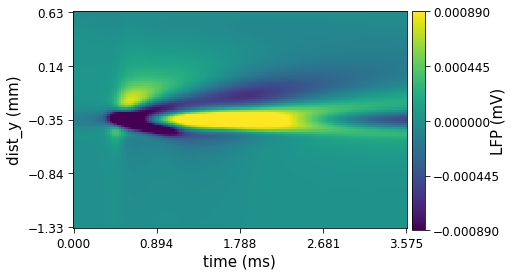

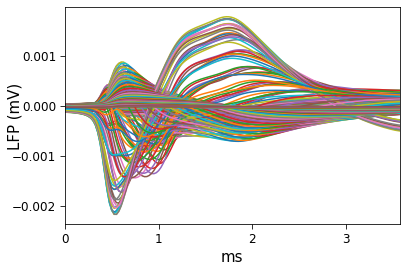

In [16]:
%matplotlib inline

ix = 1
x_dist = np.unique(coords[:,0])
e_idx = coords[:,0]==x_dist[ix]

_ = plot_lfp_heatmap(t, coords[e_idx, 1],
                     windowed_lfp[cell_idx][:, e_idx], vlim='auto',
                     fontsize=15, labelpad=-10, ticksize=12, tick_length=5, nbins=5)

_ = plot_lfp_traces(t, windowed_lfp[cell_idx], fontsize=15, labelpad=-10, ticksize=12, tick_length=5, nbins=5)